In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import logging
import numpy as np
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR)
from rbm.rbm import RBM
from ncf.ncf_singlenode import NCF
from ncf.dataset import Dataset as NCFDataset
from datasets.python_splitters import numpy_stratified_split
from datasets.python_splitters import python_chrono_split
from datasets.sparse import AffinityMatrix
from utils.timer import Timer
from utils.plot import line_graph
from datasets import movielens 
from recommenders.utils.notebook_utils import is_jupyter
from evaluation.python_evaluation import (rmse, mae, rsquared, exp_var, map_at_k, ndcg_at_k, precision_at_k, recall_at_k,)
%load_ext autoreload
%autoreload 2
print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("Tensorflow version: {}".format(tf.__version__))

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


System version: 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
Pandas version: 1.2.4
Tensorflow version: 2.3.0


In [2]:
MOVIELENS_DATA_SIZE = '100k'
mldf_100k = movielens.load_pandas_df(
    size=MOVIELENS_DATA_SIZE,
    header=['userID','movieID','rating','timestamp']
) 
mldf_100k.head()

INFO:recommenders.datasets.download_utils:Downloading https://files.grouplens.org/datasets/movielens/ml-100k.zip
100%|██████████| 4.81k/4.81k [01:44<00:00, 45.8KB/s]  


,userID,movieID,rating,timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


In [3]:
MOVIELENS_DATA_SIZE = '1m'
mldf_1m = movielens.load_pandas_df(
    size=MOVIELENS_DATA_SIZE,
    header=['userID','movieID','rating','timestamp']
)
mldf_1m.head()

INFO:recommenders.datasets.download_utils:Downloading https://files.grouplens.org/datasets/movielens/ml-1m.zip
100%|██████████| 5.78k/5.78k [01:09<00:00, 83.7KB/s] 


,userID,movieID,rating,timestamp
0,1,1193,5.0,978300760
1,1,661,3.0,978302109
2,1,914,3.0,978301968
3,1,3408,4.0,978300275
4,1,2355,5.0,978824291


In [4]:
header = {
        "col_user": "userID",
        "col_item": "movieID",
        "col_rating": "rating",
    }

In [5]:
am1m = AffinityMatrix(df = mldf_1m, **header)
X1m, _, _ = am1m.gen_affinity_matrix()

INFO:datasets.sparse:Generating the user/item affinity matrix...
INFO:datasets.sparse:Matrix generated, sparseness percentage: 95


Matrix generated, sparseness percentage: 95


In [6]:
Xtr_1m, Xtst_1m = numpy_stratified_split(X1m)

[Text(0.5, 0, 'ratings'), Text(0, 0.5, 'density')]

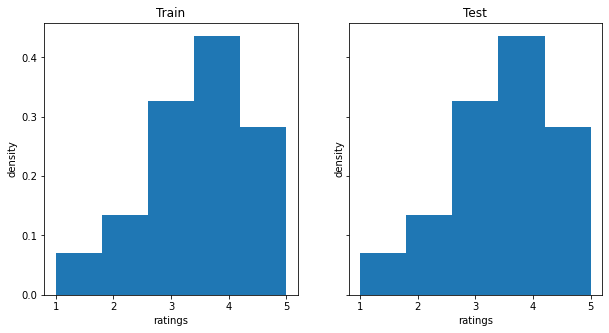

In [7]:
_, (ax1m, ax2m) = plt.subplots(1, 2, sharey=True, figsize=(10,5))
ax1m.hist(Xtr_1m[Xtr_1m !=0], 5, density= True)
ax1m.set_title('Train')
ax1m.set(xlabel="ratings", ylabel="density")
ax2m.hist(Xtst_1m[Xtst_1m !=0], 5, density= True)
ax2m.set_title('Test')
ax2m.set(xlabel="ratings", ylabel="density")

In [8]:
am100k = AffinityMatrix(df = mldf_100k, **header)
X100k, _, _= am100k.gen_affinity_matrix()
Xtr_100k, Xtst_100k = numpy_stratified_split(X100k)

INFO:datasets.sparse:Generating the user/item affinity matrix...
INFO:datasets.sparse:Matrix generated, sparseness percentage: 93


Matrix generated, sparseness percentage: 93


[Text(0.5, 0, 'ratings'), Text(0, 0.5, 'density')]

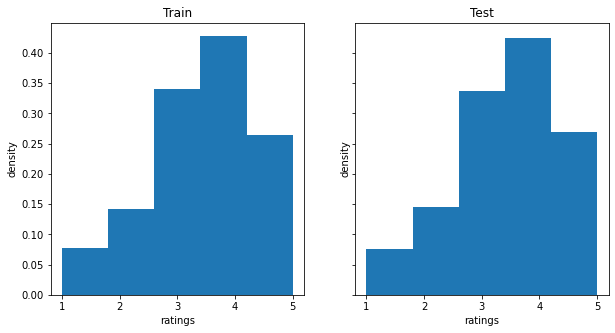

In [9]:
_, (ax1k, ax2k) = plt.subplots(1, 2, sharey=True, figsize=(10,5))
ax1k.hist(Xtr_100k[Xtr_100k !=0], 5, density= True)
ax1k.set_title('Train')
ax1k.set(xlabel="ratings", ylabel="density")
ax2k.hist(Xtst_100k[Xtst_100k !=0], 5, density= True)
ax2k.set_title('Test')
ax2k.set(xlabel="ratings", ylabel="density")

In [10]:
def ranking_metrics(data_size, data_true, data_pred, K):
    eval_map = map_at_k(data_true, data_pred, col_user="userID", col_item="movieID", 
                    col_rating="rating", col_prediction="prediction", 
                    relevancy_method="top_k", k= K)
    eval_ndcg = ndcg_at_k(data_true, data_pred, col_user="userID", col_item="movieID", 
                      col_rating="rating", col_prediction="prediction", 
                      relevancy_method="top_k", k= K)
    eval_precision = precision_at_k(data_true, data_pred, col_user="userID", col_item="movieID", 
                               col_rating="rating", col_prediction="prediction", 
                               relevancy_method="top_k", k= K)
    eval_recall = recall_at_k(data_true, data_pred, col_user="userID", col_item="movieID", 
                          col_rating="rating", col_prediction="prediction", 
                          relevancy_method="top_k", k= K)
    df_result = pd.DataFrame(
        {   "Dataset": data_size,
            "K": K,
            "MAP": eval_map,
            "nDCG@k": eval_ndcg,
            "Precision@k": eval_precision,
            "Recall@k": eval_recall,
        }, 
        index=[0]
    )
    return df_result

In [11]:
model_1m = RBM(
    possible_ratings=np.setdiff1d(np.unique(Xtr_1m), np.array([0])),
    visible_units=Xtr_1m.shape[1],
    hidden_units=1200,
    training_epoch=30,
    minibatch_size=350,
    with_metrics=True
)

INFO:rbm.rbm:Creating the computational graph
INFO:rbm.rbm:Initialize Gibbs protocol


Creating the computational graph
Initialize Gibbs protocol


INFO:rbm.rbm:training epoch 0 rmse 1.684999


training epoch 0 rmse 1.684999


INFO:rbm.rbm:training epoch 10 rmse 1.627271


training epoch 10 rmse 1.627271


INFO:rbm.rbm:training epoch 20 rmse 1.589810


training epoch 20 rmse 1.589810


INFO:rbm.rbm:training epoch 30 rmse 1.561582


training epoch 30 rmse 1.561582
Took 103.71 seconds for training.


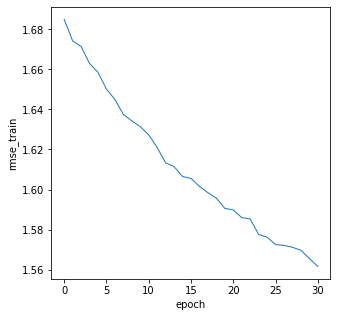

In [12]:
with Timer() as train_time:
    model_1m.fit(Xtr_1m)
print("Took {:.2f} seconds for training.".format(train_time.interval))
line_graph(values=model_1m.rmse_train, labels='train', x_name='epoch', y_name='rmse_train')

In [13]:
K = 10
with Timer() as prediction_time:
    top_k_1m =  model_1m.recommend_k_items(Xtst_1m)
print("Took {:.2f} seconds for prediction.".format(prediction_time.interval))

INFO:rbm.rbm:Extracting top 10 elements


Extracting top 10 elements
Took 3.24 seconds for prediction.


In [14]:
top_k_df_1m = am1m.map_back_sparse(top_k_1m, kind = 'prediction')
test_df_1m = am1m.map_back_sparse(Xtst_1m, kind = 'ratings')

In [15]:
rating_1m= ranking_metrics( data_size = "mv 1m", data_true = test_df_1m, data_pred = top_k_df_1m, K =10)
rating_1m

,Dataset,K,MAP,nDCG@k,Precision@k,Recall@k
0,mv 1m,10,0.271075,0.678242,0.572533,0.310171


In [16]:
model_100k = RBM(
    possible_ratings=np.setdiff1d(np.unique(Xtr_100k), np.array([0])),
    visible_units=Xtr_100k.shape[1],
    hidden_units=600,
    training_epoch=30,
    minibatch_size=60,
    keep_prob=0.9,
    with_metrics=True
)

INFO:rbm.rbm:Creating the computational graph
INFO:rbm.rbm:Initialize Gibbs protocol


Creating the computational graph
Initialize Gibbs protocol


INFO:rbm.rbm:training epoch 0 rmse 1.799513


training epoch 0 rmse 1.799513


INFO:rbm.rbm:training epoch 10 rmse 1.718070


training epoch 10 rmse 1.718070


INFO:rbm.rbm:training epoch 20 rmse 1.699357


training epoch 20 rmse 1.699357


INFO:rbm.rbm:training epoch 30 rmse 1.693338


training epoch 30 rmse 1.693338
Took 10.96 seconds for training.


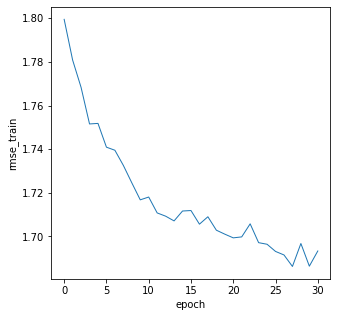

In [17]:
with Timer() as train_time:
    model_100k.fit(Xtr_100k)
print("Took {:.2f} seconds for training.".format(train_time.interval))
line_graph(values=model_100k.rmse_train, labels='train', x_name='epoch', y_name='rmse_train')

In [18]:
with Timer() as prediction_time:
    top_k_100k =  model_100k.recommend_k_items(Xtst_100k)
print("Took {:.2f} seconds for prediction.".format(prediction_time.interval))
top_k_df_100k = am100k.map_back_sparse(top_k_100k, kind = 'prediction')
test_df_100k = am100k.map_back_sparse(Xtst_100k, kind = 'ratings')

INFO:rbm.rbm:Extracting top 10 elements


Extracting top 10 elements
Took 0.25 seconds for prediction.


In [19]:
eval_100k= ranking_metrics(data_size = "mv 100k", data_true =test_df_100k,  data_pred =top_k_df_100k, K=10) 
eval_100k

,Dataset,K,MAP,nDCG@k,Precision@k,Recall@k
0,mv 100k,10,0.147031,0.418826,0.344963,0.219079


In [20]:
# top k items to recommend
TOP_K = 10

# Select MovieLens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = '100k'

# Model parameters
EPOCHS = 30
BATCH_SIZE = 30

SEED = 42

In [21]:
df = movielens.load_pandas_df(
    size=MOVIELENS_DATA_SIZE,
    header=["userID", "itemID", "rating", "timestamp"]
)

INFO:recommenders.datasets.download_utils:Downloading https://files.grouplens.org/datasets/movielens/ml-100k.zip
100%|██████████| 4.81k/4.81k [00:59<00:00, 81.2KB/s]


In [22]:
train, test = python_chrono_split(df, 0.75)

In [23]:
test = test[test["userID"].isin(train["userID"].unique())]
test = test[test["itemID"].isin(train["itemID"].unique())]

In [24]:
train_file = "./train.csv"
test_file = "./test.csv"
train.to_csv(train_file, index=False)
test.to_csv(test_file, index=False)

In [25]:
data = NCFDataset(train_file=train_file, test_file=test_file, seed=SEED)

INFO:ncf.dataset:Indexing ./train.csv ...
INFO:ncf.dataset:Indexing ./test.csv ...
INFO:ncf.dataset:Indexing ./test_full.csv ...


In [26]:
model = NCF (
    n_users=data.n_users, 
    n_items=data.n_items,
    model_type="NeuMF",
    n_factors=4,
    layer_sizes=[16,8,4],
    n_epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=1e-3,
    verbose=10,
    seed=SEED
)

In [27]:
with Timer() as train_time:
    model.fit(data)

print("Took {} seconds for training.".format(train_time))

INFO:ncf.ncf_singlenode:Epoch 10 [12.01s]: train_loss = 0.256578 
INFO:ncf.ncf_singlenode:Epoch 20 [12.16s]: train_loss = 0.245971 
INFO:ncf.ncf_singlenode:Epoch 30 [12.80s]: train_loss = 0.241049 


Took 689.2101 seconds for training.


In [28]:
with Timer() as test_time:
    users, items, preds = [], [], []
    item = list(train.itemID.unique())
    for user in train.userID.unique():
        user = [user] * len(item) 
        users.extend(user)
        items.extend(item)
        preds.extend(list(model.predict(user, item, is_list=True)))

    all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})

    merged = pd.merge(train, all_predictions, on=["userID", "itemID"], how="outer")
    all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)

print("Took {} seconds for prediction.".format(test_time))

Took 2.5269 seconds for prediction.


In [29]:
eval_map = map_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_ndcg = ndcg_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)

print("MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

MAP:	0.049837
NDCG:	0.201726
Precision@K:	0.182821
Recall@K:	0.103100


In [30]:
df = movielens.load_pandas_df(
    size='1m',
    header=["userID", "itemID", "rating", "timestamp"]
)

INFO:recommenders.datasets.download_utils:Downloading https://files.grouplens.org/datasets/movielens/ml-1m.zip
100%|██████████| 5.78k/5.78k [00:34<00:00, 167KB/s] 


In [31]:
train, test = python_chrono_split(df, 0.75)

In [32]:
test = test[test["userID"].isin(train["userID"].unique())]
test = test[test["itemID"].isin(train["itemID"].unique())]

In [33]:
train_file = "./train1.csv"
test_file = "./test1.csv"
train.to_csv(train_file, index=False)
test.to_csv(test_file, index=False)

In [34]:
data = NCFDataset(train_file=train_file, test_file=test_file, seed=SEED)

INFO:ncf.dataset:Indexing ./train1.csv ...
INFO:ncf.dataset:Indexing ./test1.csv ...
INFO:ncf.dataset:Indexing ./test1_full.csv ...


In [35]:
model = NCF (
    n_users=data.n_users, 
    n_items=data.n_items,
    model_type="NeuMF",
    n_factors=4,
    layer_sizes=[16,8,4],
    n_epochs=EPOCHS,
    batch_size=175,
    learning_rate=1e-3,
    verbose=10,
    seed=SEED
)

In [36]:
with Timer() as train_time:
    model.fit(data)

print("Took {} seconds for training.".format(train_time))

INFO:ncf.ncf_singlenode:Epoch 10 [60.14s]: train_loss = 0.270127 
INFO:ncf.ncf_singlenode:Epoch 20 [59.02s]: train_loss = 0.262926 
INFO:ncf.ncf_singlenode:Epoch 30 [53.10s]: train_loss = 0.259717 


Took 2368.8751 seconds for training.


In [37]:
with Timer() as test_time:
    users, items, preds = [], [], []
    item = list(train.itemID.unique())
    for user in train.userID.unique():
        user = [user] * len(item) 
        users.extend(user)
        items.extend(item)
        preds.extend(list(model.predict(user, item, is_list=True)))

    all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})

    merged = pd.merge(train, all_predictions, on=["userID", "itemID"], how="outer")
    all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)

print("Took {} seconds for prediction.".format(test_time))

Took 41.5399 seconds for prediction.


In [38]:
eval_map = map_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_ndcg = ndcg_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)

print("MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

MAP:	0.026933
NDCG:	0.158299
Precision@K:	0.146954
Recall@K:	0.058661
